**Models to be trained**

Model 1: <br>
- Warm-up learner: Random sampling (randomly labeling a small subset of data to bootstrap the model)
- Hot learner: Uncertainty sampling (choose points the model is least confident about (e.g., predicted probability near 0.5)
- Classifier: Random Forest

Model 2: <br>
- Warm-up learner: Random sampling (randomly labeling a small subset of data to bootstrap the model)
- Hot learner: Expected Model Change (select samples that are expected to cause the biggest change in model params)
- Classifier: Random Forest


In [27]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scipy.stats import entropy  

In [ ]:
# Load data
class_df = pd.read_csv("elliptic_txs_classes.csv")
edge_df = pd.read_csv(r"elliptic_txs_edgelist.csv")
feature_df = pd.read_csv(r"elliptic_txs_features.csv", header=None)

# Create column names
colnames1 = {'0': 'txId', 1: "time_step"}
colnames2 = {str(ii+2): "local_feature_" + str(ii+1) for ii in range(93)}
colnames3 = {str(ii+95): "aggregate_feature_" + str(ii+1) for ii in range(72)}

colnames = dict(colnames1, **colnames2, **colnames3 )
colnames = {int(jj): item_kk for jj,item_kk in colnames.items()}
feature_df = feature_df.rename(columns=colnames)

# Change unknown class to 3, 2 is licit, 1 is illicit
class_df.loc[class_df['class'] == 'unknown', 'class'] = 3 # note that "unknown" is not counted as a label, just for readability
df = pd.merge(class_df, feature_df ) # merge class csv with features csv

# Split train-test data based on time steps (Weber et al)
df['class'] = df['class'].astype(int)
df['time_step'] = df['time_step'].astype(int)

df_labeled = df[df['class'].isin([1, 2])] # only include labeled samples

df['time_step'] = df['time_step'].astype(int)
train_df = df_labeled[df_labeled['time_step'] <= 34].copy()
test_df = df_labeled[df_labeled['time_step'] >= 35].copy()

# Extract features and labels for train/test
feature_cols = [col for col in df.columns if col.startswith("local_") or col.startswith("aggregate_")]

X_train_full = train_df[feature_cols].values
y_train_full = train_df['class'].map({1:1, 2:0}).values # map labels: illicit=1, licit=0

X_test = test_df[feature_cols].values
y_test = test_df['class'].map({1:1, 2:0}).values

time_steps_test = test_df['time_step'].values

print(X_train.shape)
print(X_test.shape)

(29894, 165)
(16670, 165)


Running Model 1: Random warm-up + Uncertainty sampling + RF
Iteration 1/50, Labeled size: 100, F1(illicit) = 0.5549
Iteration 2/50, Labeled size: 150, F1(illicit) = 0.7043
Iteration 3/50, Labeled size: 200, F1(illicit) = 0.6926
Iteration 4/50, Labeled size: 250, F1(illicit) = 0.6918
Iteration 5/50, Labeled size: 300, F1(illicit) = 0.7288
Iteration 6/50, Labeled size: 350, F1(illicit) = 0.7811
Iteration 7/50, Labeled size: 400, F1(illicit) = 0.7602
Iteration 8/50, Labeled size: 450, F1(illicit) = 0.7717
Iteration 9/50, Labeled size: 500, F1(illicit) = 0.7856
Iteration 10/50, Labeled size: 550, F1(illicit) = 0.7982
Iteration 11/50, Labeled size: 600, F1(illicit) = 0.7887
Iteration 12/50, Labeled size: 650, F1(illicit) = 0.7824
Iteration 13/50, Labeled size: 700, F1(illicit) = 0.8093
Iteration 14/50, Labeled size: 750, F1(illicit) = 0.8025
Iteration 15/50, Labeled size: 800, F1(illicit) = 0.8157
Iteration 16/50, Labeled size: 850, F1(illicit) = 0.8118
Iteration 17/50, Labeled size: 900, F

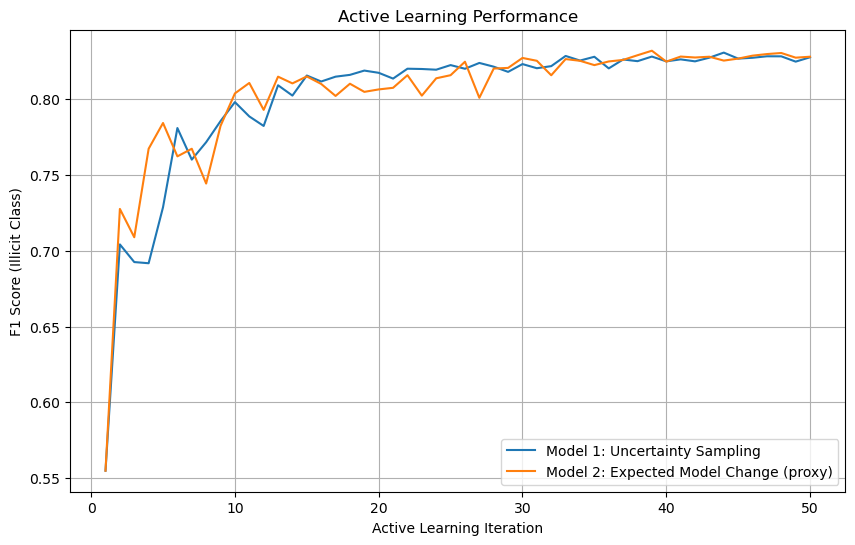

In [29]:
# --- Sampling strategies ---

def random_sampling(unlabeled_idx, n_instances):
    return np.random.choice(unlabeled_idx, size=n_instances, replace=False)

def uncertainty_sampling(probs, n_instances):
    uncertainty = np.abs(probs[:,1] - 0.5)
    query_idx = np.argsort(uncertainty)[:n_instances]
    return query_idx

def expected_model_change_sampling_rf(probs, n_instances):
    # Approximate EMC for RF by using predictive entropy as proxy
    # probs shape (n_samples, n_classes)
    ent = entropy(probs.T)
    query_idx = np.argsort(ent)[-n_instances:]  # highest entropy (most info gain)
    return query_idx

# --- Active Learning loop for the two models ---

def active_learning_loop(X_train, y_train, X_test, y_test, time_steps_test,
                         warmup_size=100, batch_size=50, max_iters=50,
                         hot_learner='uncertainty'):
    np.random.seed(42)

    n_samples = X_train.shape[0]
    unlabeled_idx = np.arange(n_samples)
    labeled_idx = np.array([], dtype=int)

    # Warm-up learner: randomly label warmup_size samples
    warmup_idx = random_sampling(unlabeled_idx, warmup_size)
    labeled_idx = np.concatenate([labeled_idx, warmup_idx])
    unlabeled_idx = np.array([i for i in unlabeled_idx if i not in warmup_idx])

    f1_scores = []

    for it in range(max_iters):
        # Train RF classifier on labeled data
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train[labeled_idx], y_train[labeled_idx])

        # Evaluate on test set, F1 for illicit class=1
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        f1_scores.append(f1)
        print(f"Iteration {it+1}/{max_iters}, Labeled size: {len(labeled_idx)}, F1(illicit) = {f1:.4f}")

        if len(unlabeled_idx) == 0:
            print("No more unlabeled samples.")
            break

        # Hot learner selects samples from unlabeled
        probs = clf.predict_proba(X_train[unlabeled_idx])

        if hot_learner == 'uncertainty':
            query_rel_idx = uncertainty_sampling(probs, batch_size)
        elif hot_learner == 'expected_model_change':
            query_rel_idx = expected_model_change_sampling_rf(probs, batch_size)
        else:
            raise ValueError("hot_learner must be 'uncertainty' or 'expected_model_change'")

        query_idx = unlabeled_idx[query_rel_idx]

        # Add queried samples to labeled set, remove from unlabeled set
        labeled_idx = np.concatenate([labeled_idx, query_idx])
        unlabeled_idx = np.array([i for i in unlabeled_idx if i not in query_idx])

    return f1_scores

# --- Run both models ---

print("Running Model 1: Random warm-up + Uncertainty sampling + RF")
f1_model1 = active_learning_loop(
    X_train_full, y_train_full, X_test, y_test, time_steps_test,
    hot_learner='uncertainty'
)

print("\nRunning Model 2: Random warm-up + Expected Model Change sampling (proxy) + RF")
f1_model2 = active_learning_loop(
    X_train_full, y_train_full, X_test, y_test, time_steps_test,
    hot_learner='expected_model_change'
)

# --- Plot results ---

plt.figure(figsize=(10,6))
plt.plot(range(1, len(f1_model1)+1), f1_model1, label='Model 1: Uncertainty Sampling')
plt.plot(range(1, len(f1_model2)+1), f1_model2, label='Model 2: Expected Model Change (proxy)')
plt.xlabel('Active Learning Iteration')
plt.ylabel('F1 Score (Illicit Class)')
plt.title('Active Learning Performance')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
!pip install modAL


In [34]:
import sys
import numpy
import scipy
import sklearn
print("Python version:", sys.version)
print("NumPy version:", numpy.__version__)
print("SciPy version:", scipy.__version__)
print("scikit-learn version:", sklearn.__version__)

Python version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
NumPy version: 1.26.4
SciPy version: 1.13.1
scikit-learn version: 1.5.1


In [41]:
pip install modAL

Note: you may need to restart the kernel to use updated packages.


In [42]:
import sys
print(sys.executable)

C:\Anaconda\python.exe


In [ ]:
print(modAL.__version__)

ModuleNotFoundError: No module named 'modAL'

# Old code (its in markdown mode)

def uncertainty_sampling(probs, n_instances):
    # probs: shape (n_samples, 2) for class probabilities
    # Select instances closest to 0.5 probability for positive class (illicit=1)
    uncertainty = np.abs(probs[:,1] - 0.5)
    query_idx = np.argsort(uncertainty)[:n_instances]
    return query_idx

# Initialize labeled and unlabeled pools
np.random.seed(42)
initial_label_count = 100

# Start with a small random labeled set
labeled_idx = np.random.choice(len(X_train), size=initial_label_count, replace=False)
unlabeled_idx = np.array([i for i in range(len(X_train)) if i not in labeled_idx])

# Track performance
f1_scores = []

n_queries_per_iter = 50
max_iterations = 30

for it in range(max_iterations):
    # Train model on labeled set
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train[labeled_idx], y_train[labeled_idx])

    # Predict on test set and evaluate
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    f1_scores.append(f1)
    print(f"Iteration {it}: F1 (illicit class) = {f1:.4f}")

    if len(unlabeled_idx) == 0:
        print("No more unlabeled samples to query.")
        break

    # Predict probabilities on unlabeled pool
    probs = clf.predict_proba(X_train[unlabeled_idx])

    # Query uncertain samples
    query_idx_relative = uncertainty_sampling(probs, n_queries_per_iter)
    query_idx = unlabeled_idx[query_idx_relative]

    # Add queried samples to labeled set
    labeled_idx = np.concatenate([labeled_idx, query_idx])

    # Remove queried samples from unlabeled set
    unlabeled_idx = np.array([i for i in unlabeled_idx if i not in query_idx])

# Plot F1 scores over iterations
import matplotlib.pyplot as plt
plt.plot(range(len(f1_scores)), f1_scores, marker='o')
plt.xlabel('Active Learning Iteration')
plt.ylabel('F1 Score (Illicit Class)')
plt.title('Active Learning: Uncertainty Sampling + Random Forest')
plt.grid(True)
plt.show()